Document by Mathijs Rozemuller

Goal: Compare FEWSNET data with the crop yield.
Is FEWSNET level 3 a good predictor of a low crop yield?


Conclusion:
- Crop yield data only exists until 2016 and the FEWSNET data from 2007, leaving a small time window
- The long term prediction is almost never a level 3 alert. (There were more level 3 predictions in 2016, but there's no crop yield data
- Therefore long term predictions are basically useless now. It might change if crop yield data could be inlcuded of later years.

- Current predictions of October more often have level 3 and have a very high likelyhood of a negative Z-score. However, no threshold can be made with a false positive rate exceeding ~40%.

# Calculate Exposed Population to IPC-Class 3

This script makes use of the FEWSNET Food Security classification, which is classified according to the [Integrated Phase Classification (IPC) V3.0](https://fews.net/IPC). 

The zips files to be downloaded in this script contains three files 

* _CS: Current Situation
* _ML1: Near-term projection - (next month)
* _ML2: Medium-term projection - (next four months)

The shapefiles contain the phases of food security for that period. The five phases are: 
1. Minimal
2. Stressed
3. Crisis
4. Emergency
5. Famine

Other additional values which might occur in the shapefiles include 
66 = water, 88 = parks, forests, reserves, 99 = No Data or Missing Data. 

More information [FEWSNET Food Securty Data](http://shapefiles.fews.net.s3.amazonaws.com/HFIC/FEWS_NET_Food_Security_Data_v3.pdf)

# Import packages

In [5]:
#!/usr/bin/env python
# coding: utf-8

#Make sure you have the ritht folder structure
#../data/Shapefile
# .../data/Shapefile/South_Africa_Zips

import subprocess
import requests
import urllib.request
import zipfile
import os
import shutil
import geopandas as gpd
from bs4 import BeautifulSoup
import urllib.request
from os import listdir
from os.path import isfile, join
import pandas as pd
import ee
import os
import glob
from zipfile import ZipFile
import datetime as dt

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
 
import descartes 
import mapclassify
from matplotlib.pyplot import figure
import numpy as np

plt.style.use('seaborn-poster')

In [6]:
#plt.style.available

**NOTE: Download FEWSNET Data within https://github.com/rodekruis/IBF-system/blob/master/trigger-model-development/drought/skill-assessment/ipc_class/ipc_class_exposed_pop.ipynb .**

### FEWSNET IPC Maps  

In [750]:
# Several plots will be generated with the function plot_geo:
def plot_geo_acc(df1, district,year):
    fig, ax = plt.subplots(figsize = (20,10)) 
    ax.axis("off")
    df1=df1.query('CS > 1')
    df1 = df1.astype({"CS": int})
    colors2=['#f0f9e8','#ffffb2','#fe9929','#e31a1c','#d94701']
    cmap1 = ListedColormap(colors2)
    #df1.plot(column ='CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.1, edgecolor='0.8',vmin=1, vmax=5)
    district.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
    plt.title('FEWS NET IPC-%s '%year)

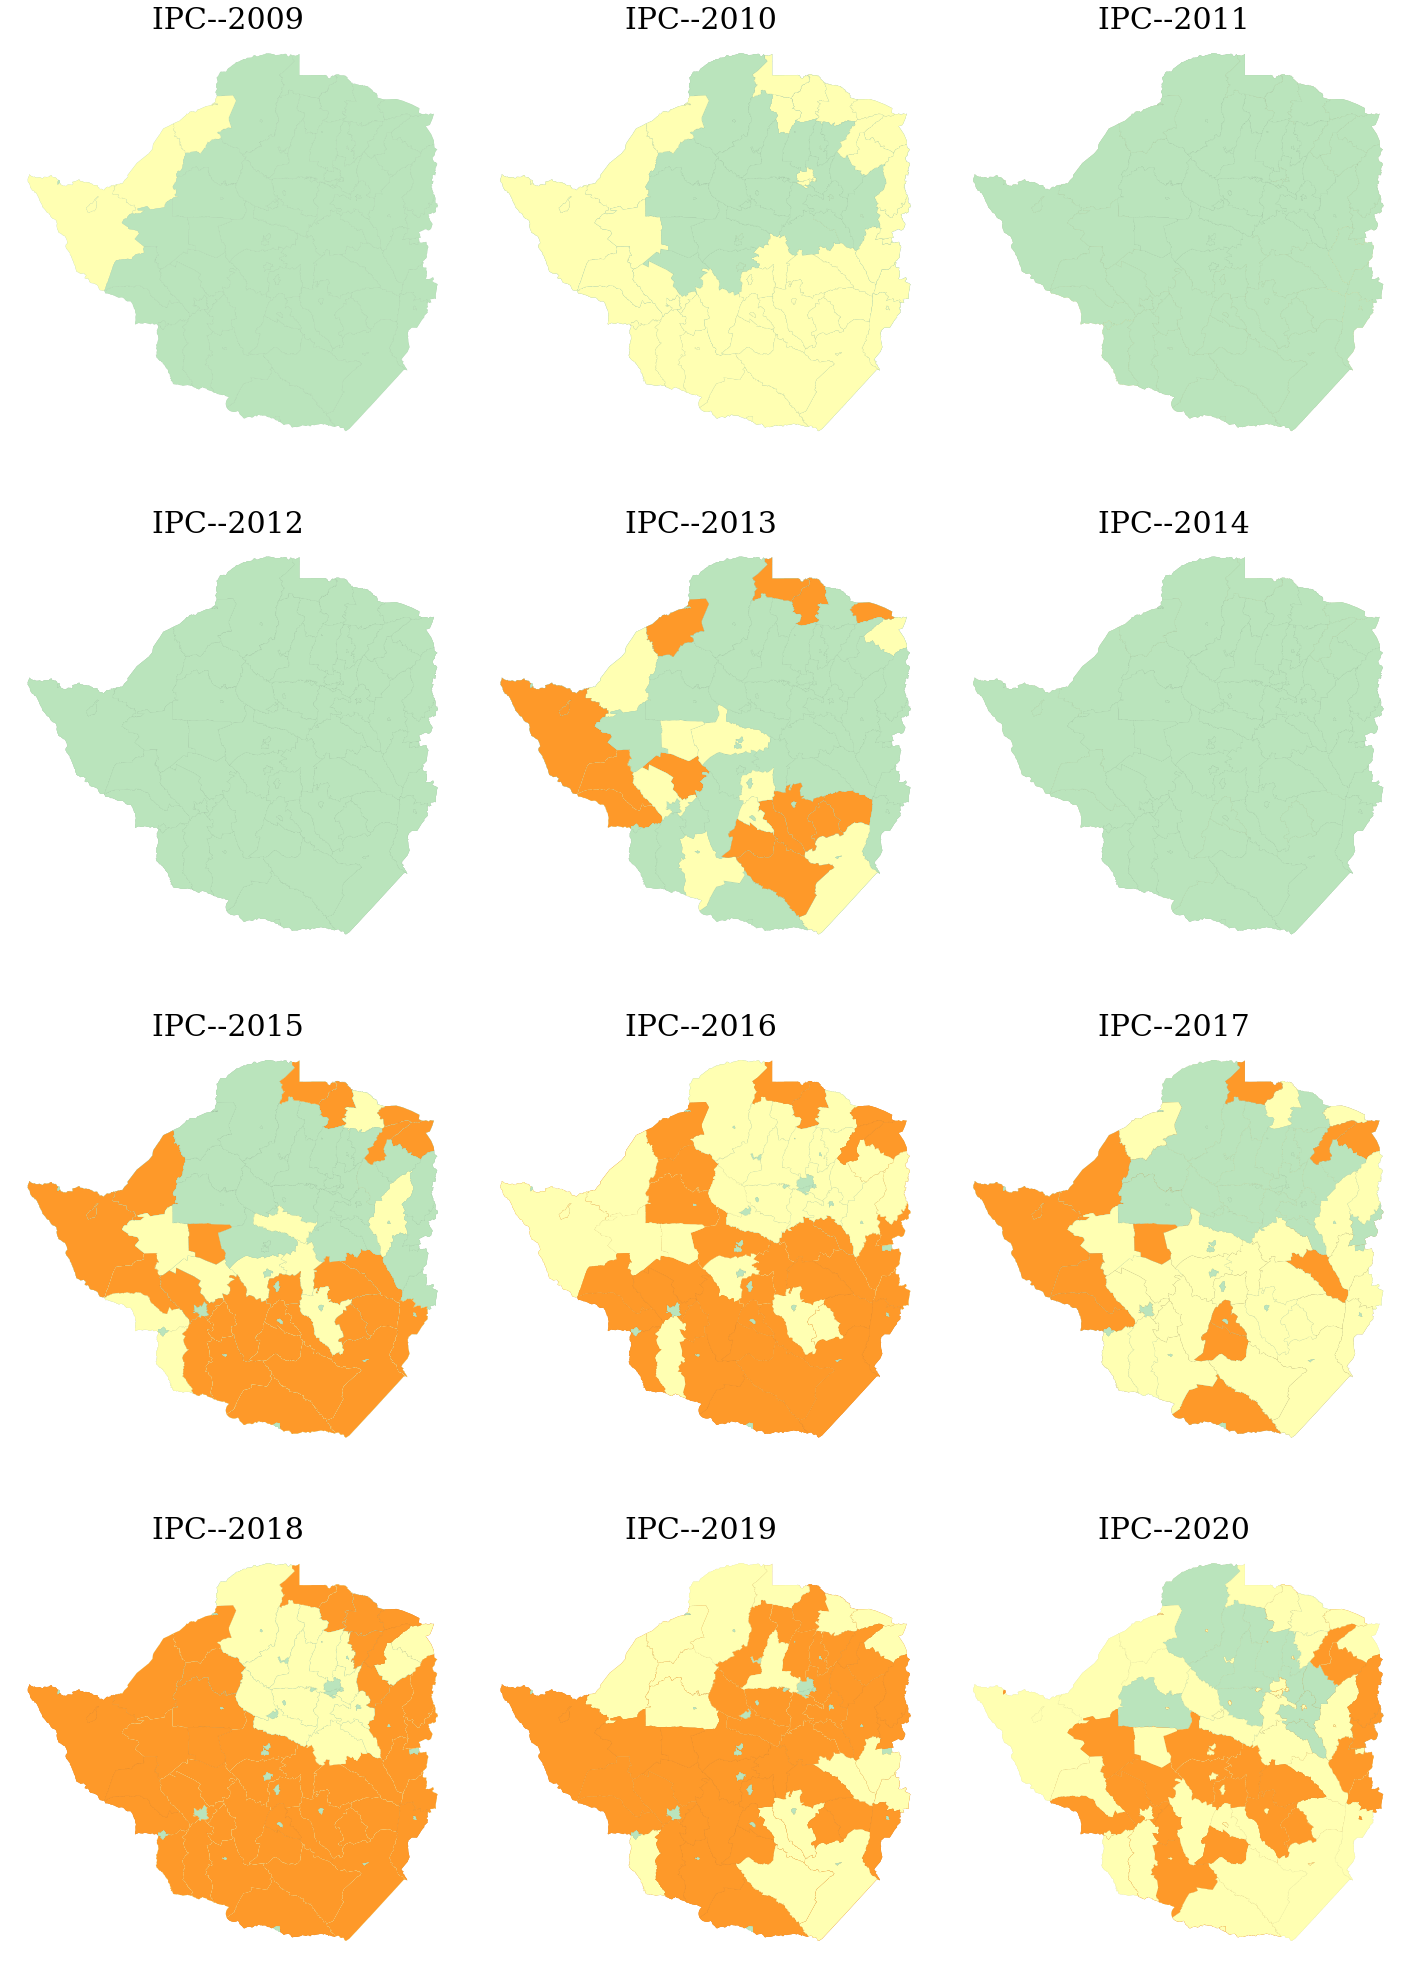

In [751]:
fig1= plt.figure( figsize=(20, 30))
#c=9
for i,Y in enumerate(years):
    
    ax = fig1.add_subplot(4, int(float(len(years)+3)/4.), i+1)  # create an axes object in the figure
    
    plot_df=df2.query('year==%s'% (Y)) #select a certain year
    year='-%s'% (Y)
    df=plot_df.query('CS > 1') #select data with CS>1
    df = df.astype({"CS": int})
    #colors2=["#bababa","#e0e0e0","#ffffff","#fb6a4a","#de2d26"]
    #colors2=['#f6eff7','#f0f9e8','#ffffb2','#fe9929','#e31a1c','#d94701']
    colors2=['#f0f9e8','#bae4bc','#ffffb2','#fe9929','#e31a1c','#59140d']
    cmap1 = ListedColormap(colors2)
    #plot the map allong column CS
    s1=plot_df.plot(column = 'CS',ax=ax, legend = False, cmap =cmap1,linewidth=0.02, edgecolor='0.4',vmin=-0.5, vmax=6)
    ax.axis('off')
    #plt.clim(1,5) 
    #POSTO.geometry.boundary.plot(color=None,edgecolor='black',linewidth = .1,ax=ax)
    plt.title('IPC-%s '%year,fontsize='30')
    #fig.colorbar(cs, ax=ax, shrink=0.9)
    #c=c+1
    plt.tight_layout()

# Do the anomaly detection

In [1102]:
#load data
Yield_data=pd.read_csv(os.path.split(mypath2)[0]+r'\data\zwe_cropyield\all_yield_global_dataset.csv')
Yield_data['Z-score']=np.nan #add column for the Z-scores
Yield_data['Z-moveAv']=np.nan #add column for the Z-scores
Yield_data['yield_movAv']=np.nan #add column for the moving average
Yield_data['yield_movDev']=np.nan #add column for the difference with respect ot the moving average
Yield_data['Anomaly']=np.nan #add column for the difference with respect ot the moving average
Yield_data['AnomalyMovAv']=np.nan #add column for the difference with respect ot the moving average

Yield_data.columns

Index(['pcode', 'year', 'yield', 'Z-score', 'Z-moveAv', 'yield_movAv',
       'yield_movDev', 'Anomaly', 'AnomalyMovAv'],
      dtype='object')

In [1103]:
Zsc = lambda x : (x-x.mean())/x.std()
Nav=5 #Use the moving average of the last 5 years

#Compute the Z-score
PCodes=Yield_data.pcode.unique()
for pc in PCodes:
    sel=np.logical_and(Yield_data['pcode']==pc,~np.isnan(Yield_data['yield']))
    Yield_data.loc[sel,'Z-score']=Zsc(Yield_data['yield'][sel])

    #Compute the deviation from the Nav (5) year average
    for Y in Yield_data[sel]['year']:
        sel2=np.logical_and(Yield_data[sel]['year']>Y-Nav,Yield_data[sel]['year']<=Y)
        if sel2.sum()==Nav:
            Ym=Yield_data[sel][sel2]['yield'].mean()
            #sY=Yield_data.query('year == @Y and pcode == @pc')
            sY=np.logical_and(Yield_data['year']==Y,Yield_data['pcode']==pc)
            Yield_data.loc[sY,'yield_movAv']=Ym
Yield_data['yield_movDev']=Yield_data['yield']-Yield_data['yield_movAv']

for pc in PCodes:
    sel=np.logical_and(Yield_data['pcode']==pc,~np.isnan(Yield_data['yield_movDev']))
    Yield_data.loc[sel,'Z-moveAv']=Zsc(Yield_data['yield_movDev'][sel])
            
#Yield_data.groupby([])

In [1104]:
Yield_data['Z-moveAv_NextYear']=0#np.nan
for pc in Yield_data['pcode'].unique():
    yrs=Yield_data.loc[Yield_data['pcode']==pc,'year']
    for y in yrs:
        if y+1 in np.array(yrs):
            nv_=Yield_data[ ( Yield_data.pcode == pc ) & (Yield_data.year==y+1)]['Z-moveAv']    
            Yield_data.loc[ ( Yield_data.pcode == pc ) & (Yield_data.year==y) , 'Z-moveAv_NextYear'] = np.copy(nv_)

In [1105]:
#Yield_data[Yield_data.pcode==Yield_data['pcode'].unique()[5]]

Fraction of anomalies using a Z-score threshold of 0 : 0.291
Fraction of anomalies using deviate Z-score threshold of 0 : 0.182


[0.03375527426160337,
 0.08157524613220815,
 0.14627285513361463,
 0.2489451476793249,
 0.5035161744022504]

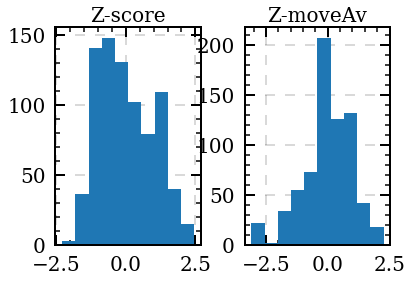

In [1106]:
#Anomaly detection using the Z-score
Yield_data.hist(column=['Z-score','Z-moveAv'])
Yield_data['LZCODE']=Yield_data['pcode']

AnomThr=-.5

Yield_data['Anomaly']=Yield_data['Z-score']<AnomThr
Yield_data['AnomalyMovAv']=Yield_data['Z-moveAv']<AnomThr
print('Fraction of anomalies using a Z-score threshold of %d : %2.3f'%(AnomThr,Yield_data['Anomaly'].mean()))
print('Fraction of anomalies using deviate Z-score threshold of %d : %2.3f'%(AnomThr,Yield_data['AnomalyMovAv'].mean()))

d=Yield_data['Z-moveAv'][~np.isnan(Yield_data['Z-moveAv'])]
[(d<a).mean() for a in [-2,-1.5,-1,-0.5,0]]

# Match the pcodes with the livelihoodzones

In [1107]:
Intc=gpd.overlay(district, zwe_lzh,how='intersection') 
Intc["area_overlap"]=Intc['geometry'].area
Intc["area_LZtot"]=np.nan

<ipython-input-1107-b9f0289810fa>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Intc["area_overlap"]=Intc['geometry'].area


In [1108]:
IntSel=Intc[['ADM2_PCODE','area_overlap','LZCODE','area_LZtot']]
for Pcode in IntSel['ADM2_PCODE'].unique():
    totArea=IntSel[IntSel['ADM2_PCODE'] == Pcode]['area_overlap'].sum()
    IntSel.loc[IntSel.ADM2_PCODE==Pcode, 'area_LZtot'] = totArea

idx=IntSel.groupby(['ADM2_PCODE'])['area_overlap'].transform(max) == IntSel['area_overlap']
IntSel_maxCorArea=IntSel[idx]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [1109]:
#merge the yield data with the translation data (from the districts to the livelihood zones)

df3=Yield_data.dropna().merge(IntSel_maxCorArea, on = 'LZCODE')
#There's fewer livelihood zones than the original 91, because not all of them have data. The dropna kills 5 zones.

In [1126]:
# Now also merge the alarm data in here
#df4 = df3.merge(IntSel_maxCorArea, on = 'ADM2_PCODE') #This merges the district info with the data along the 'ADM2_PCODE' axis
df4 = df3.merge(df2, on = ['ADM2_PCODE','year']) #This merges the district info with the data along the 'ADM2_PCODE' axis
df4['alertCS']=df4['CS']>=3
df4['alertML2']=df4['ML2']>=3
df4.loc[df4['Z-moveAv_NextYear']==0,'Z-moveAv_NextYear']=np.nan

In [1127]:
#If needed use a different anomaly threshold
AnomThr=-0.2

df4['Anomaly']=df4['Z-score']<AnomThr
df4['AnomalyMovAv']=df4['Z-moveAv']<AnomThr
df4['AnomalyMovAvNY']=df4['Z-moveAv_NextYear']<AnomThr

print('Fraction of anomalies using a Z-score threshold of %d : %2.3f'%(AnomThr,df4['Anomaly'].mean()))
print('Fraction of anomalies using deviate Z-score threshold of %d : %2.3f'%(AnomThr,df4['AnomalyMovAv'].mean()))

Fraction of anomalies using a Z-score threshold of 0 : 0.758
Fraction of anomalies using deviate Z-score threshold of 0 : 0.281


In [1128]:
#Only select the 10th month
idx = pd.to_datetime(df4['Date']).map(lambda x:x.month) == 10
df5=df4[idx]

In [1129]:
def PNmat(A,B):
    #Assumes A is the true matrix and B the predictor
    #Computes the true/false positive/negative terms
    #returns [TP,TN,FP,FN]
    TP=np.logical_and(A,B).sum()
    TN=np.logical_and(~A,~B).sum()
    FP=np.logical_and(A,~B).sum()
    FN=np.logical_and(~A,B).sum()
    return(TP,TN,FP,FN)

dfPNm = lambda x,n1,n2:PNmat(x[n1],x[n2])
dfPNmNextYear = lambda x,n1,n2:PNmat(x[n1][1:],x[n2][:-1])

### Prediction of the current FEWSNET alerty level situation in October for the same year

In [1130]:
df_EffectivityCS=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    TFmat=dfPNm(df5[df5['ADM2_PCODE']==Pcode],'AnomalyMovAv','alertCS')#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_EffectivityCS.loc[i]=rd
    
    #print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_EffectivityCS

ADM2_PCODE TP TN FP FN
0      ZW1601  2  6  0  0
1      ZW1606  1  6  1  0
2      ZW1307  0  6  2  0
3      ZW1702  0  5  0  0
4      ZW1502  1  5  1  1
..        ... .. .. .. ..
56     ZW1802  2  5  1  0
57     ZW1402  0  5  3  0
58     ZW1503  2  5  1  0
59     ZW1404  2  5  1  0
60     ZW1424  0  5  3  0

[61 rows x 5 columns]

In [1131]:
df_EffectivityCS.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                           62
TN                                                          338
FP                                                           73
FN                                                           12
dtype: object

In [1132]:
print(df_EffectivityCS.to_string())

   ADM2_PCODE TP TN FP FN
0      ZW1601  2  6  0  0
1      ZW1606  1  6  1  0
2      ZW1307  0  6  2  0
3      ZW1702  0  5  0  0
4      ZW1502  1  5  1  1
5      ZW1505  1  6  1  0
6      ZW1305  2  5  1  0
7      ZW1107  0  5  3  0
8      ZW1206  3  5  0  0
9      ZW1309  2  5  1  0
10     ZW1201  0  6  2  0
11     ZW1401  0  6  2  0
12     ZW1302  0  6  2  0
13     ZW1203  0  6  2  0
14     ZW1303  1  6  1  0
15     ZW1405  0  6  2  0
16     ZW1304  0  6  2  0
17     ZW1204  0  6  2  0
18     ZW1308  0  6  2  0
19     ZW1406  0  6  2  0
20     ZW1104  0  6  2  0
21     ZW1427  0  6  2  0
22     ZW1205  0  6  2  0
23     ZW1306  0  6  2  0
24     ZW1207  0  6  2  0
25     ZW1521  1  5  1  1
26     ZW1504  0  6  2  0
27     ZW1703  1  6  1  0
28     ZW1428  0  6  2  0
29     ZW1101  2  6  0  0
30     ZW1102  1  6  1  0
31     ZW1804  2  6  0  0
32     ZW1805  0  5  2  1
33     ZW1105  1  6  1  0
34     ZW1807  1  5  1  1
35     ZW1708  2  6  0  0
36     ZW1706  2  5  0  1
37     ZW160

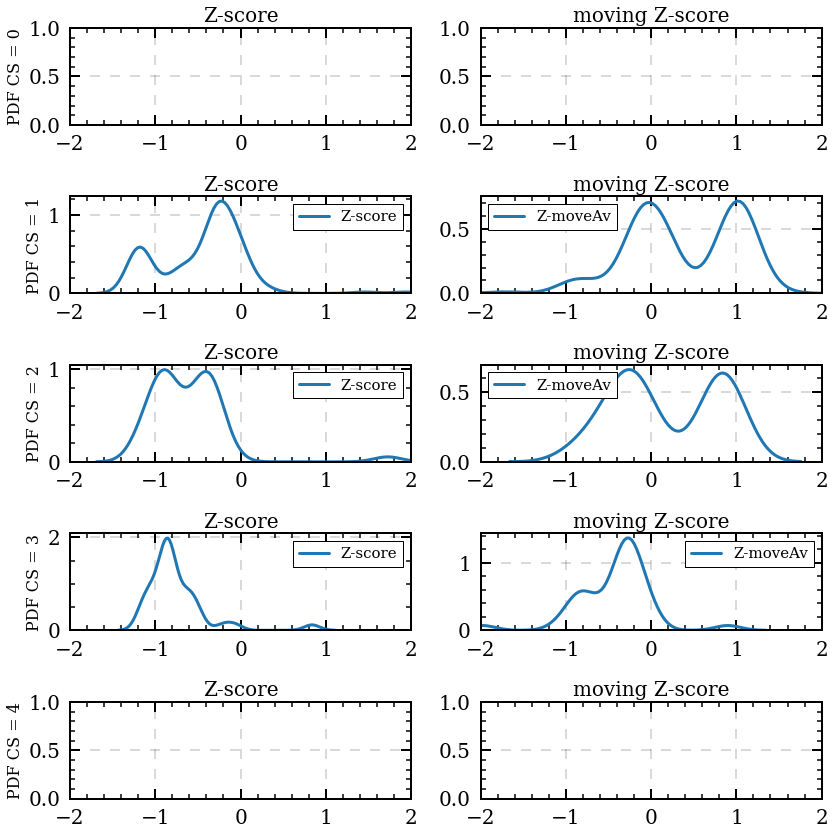

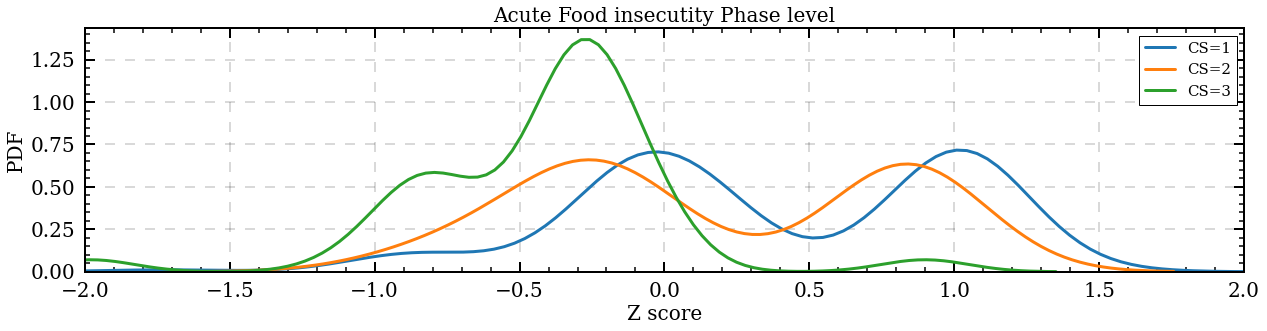

In [1133]:
#How do the CS levels (October) correspond to the yield of the same year?
plt.figure(figsize=(12,12))
for cs in range(5):
    Zsc=df5[df5['CS']==cs]['Z-score']
    ZscA=df5[df5['CS']==cs]['Z-moveAv']
    plt.subplot(5,2,2*cs+1)
    sns.kdeplot(Zsc)
    plt.title('Z-score')
    plt.ylabel(r'PDF CS = %d'%cs,fontsize=16)
    plt.xlim(-2.,2.)
    plt.subplot(5,2,2*cs+2)
    sns.kdeplot(ZscA)
    plt.title('moving Z-score')
    plt.xlim(-2.,2.)
plt.tight_layout()
plt.show()


plt.figure(figsize=(18,5))
plt.title('Acute Food insecutity Phase level')
for ip,cs in enumerate(np.arange(1,4)):
    ZscA=df5[df5['CS']==cs]['Z-moveAv']
    #plt.subplot(1,3,ip+1)
    plt.ylabel(r'PDF')
    sns.kdeplot(ZscA,label='CS=%d'%cs)
    #plt.title('moving Z-score')
    plt.xlim(-2.,2.)
    plt.xlabel('Z score')

plt.tight_layout()
plt.show()

### Comparing of the long term (level 2) FEWSNET alerty level prediction in October with the crop yield of next year

In [1134]:
def get2VShift(df,n1,n2):
    Y=np.array(df['year'])
    ML2d=np.array(df[n1])
    Anomal=np.array(df[n2])
    ML2new=[];yieldNew=[]
    for iy,y in enumerate(Y):
        loc=np.where(Y==y+1)[0]
        if len(loc)==1:
            ML2new.append(ML2d[iy]) #take the long term prediction from year x
            yieldNew.append(Anomal[loc[0]]) #and the yield from x+1
    ML2new=np.array(ML2new);yieldNew=np.array(yieldNew)
    return ML2new,yieldNew
    
#df5[df5['ADM2_PCODE']==Pcode]['year','AnomalyMovAv','ML2']

In [1135]:
df_Effectivity_ML2=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])

ML2All=[];yieldAll=[]
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    ML2new,yieldNew=get2VShift(df5[df5['ADM2_PCODE']==Pcode],'ML2','AnomalyMovAv')
    TFmat=PNmat(ML2new>=3,yieldNew)#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_Effectivity_ML2.loc[i]=rd
    ML2All.append(ML2new)
    yieldAll.append(yieldNew)
ML2All=np.hstack(ML2All)
yieldAll=np.hstack(yieldAll)
#print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_Effectivity_ML2

ADM2_PCODE TP TN FP FN
0      ZW1601  0  5  0  2
1      ZW1606  0  5  0  2
2      ZW1307  0  5  0  2
3      ZW1702  0  4  0  0
4      ZW1502  0  5  0  2
..        ... .. .. .. ..
56     ZW1802  0  4  0  3
57     ZW1402  0  4  0  3
58     ZW1503  0  3  1  3
59     ZW1404  0  3  1  3
60     ZW1424  0  4  0  3

[61 rows x 5 columns]

In [1136]:
df_Effectivity_ML2.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                            5
TN                                                          286
FP                                                            3
FN                                                          130
dtype: object

In [1137]:
df_Effectivity_ML2=pd.DataFrame(columns=['ADM2_PCODE','TP','TN','FP','FN'])
for i,Pcode in enumerate(df5['ADM2_PCODE'].unique()):
    TFmat=dfPNm(df5[df5['ADM2_PCODE']==Pcode],'AnomalyMovAvNY','alertML2')#MovAv
    rd={'ADM2_PCODE' : Pcode, 'TP' : TFmat[0],'TN' : TFmat[1],'FP' : TFmat[2],'FN' : TFmat[3]}
    df_Effectivity_ML2.loc[i]=rd
    
    #print(dfPNm(df5[df5['ADM2_PCODE']=='ZW1602'],'AnomalyMovAv','alert'))
df_Effectivity_ML2

ADM2_PCODE TP TN FP FN
0      ZW1601  0  5  2  1
1      ZW1606  0  5  2  1
2      ZW1307  0  6  2  0
3      ZW1702  0  5  0  0
4      ZW1502  0  5  2  1
..        ... .. .. .. ..
56     ZW1802  0  4  3  1
57     ZW1402  0  5  3  0
58     ZW1503  0  4  3  1
59     ZW1404  0  3  3  2
60     ZW1424  0  5  3  0

[61 rows x 5 columns]

In [1138]:
df_Effectivity_ML2.sum()

ADM2_PCODE    ZW1601ZW1606ZW1307ZW1702ZW1502ZW1505ZW1305ZW11...
TP                                                            5
TN                                                          306
FP                                                          130
FN                                                           44
dtype: object

1 229
2 188
3 8


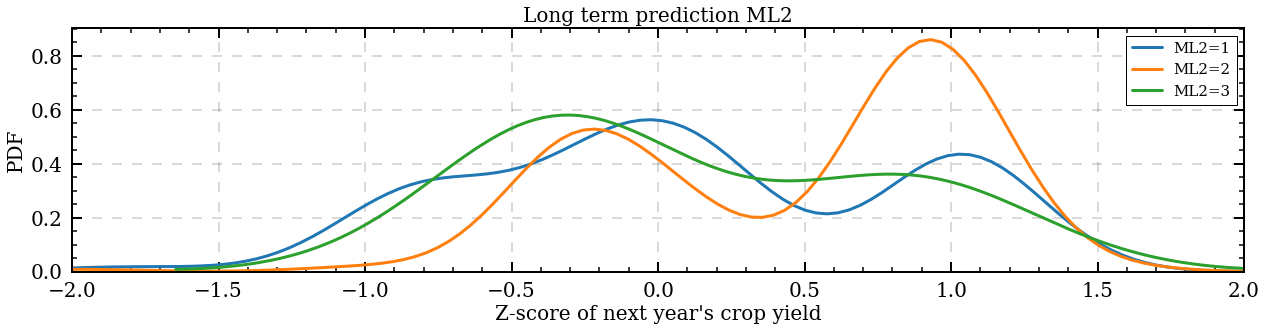

In [1152]:
plt.figure(figsize=(18,5))
plt.title('Long term prediction ML2')
for ip,level in enumerate(np.arange(1,4)):
    ZscA=df5[df5['ML2']==level]['Z-moveAv_NextYear'].dropna()
    print(level,len(ZscA))
    #plt.subplot(1,3,ip+1)
    plt.ylabel(r'PDF')
    sns.kdeplot(ZscA,label='ML2=%d'%level)
    #plt.title('moving Z-score')
    plt.xlim(-2.,2.)
    plt.xlabel("Z-score of next year's crop yield")

plt.tight_layout()
plt.show()